Ref: https://www.kaggle.com/shivamb/ideas-for-image-features-and-image-quality

## Image Features:
- Image Dullness Score
- Average Pixel Width (check if the image's pixel color is very uniform - i.e. the image is very 'flat')
- Blurness
- Width of the Image
- Height of the Image
- Size of the Image
- Neural Net Object Prediction
- image quality by using: https://github.com/titu1994/neural-image-assessment (not in this notebook)
- Keypoint extraction

## Knowledge points:
- Check invalid images in the image folder
- Use Dusk to multiprocess on dataframe
- Use tqdm for progress bar in Pandas
- Force to use one specific GPU, so it won't occupy the other GPUs memories
- Use .apply() for mulitple output columns [Go to](#apply_multiple)

In [5]:
from collections import defaultdict
from scipy.stats import itemfreq
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib.image as matImage
from skimage import feature
from PIL import Image  # as IMG
import numpy as np
import pandas as pd 
import operator
import cv2
import os
import pickle
from tqdm import tqdm
import dask.dataframe as dd

from IPython.core.display import HTML 
from IPython.display import Image

pd.options.display.max_columns = 999
%matplotlib inline

from PIL import Image

## Image Feature Engineering by Pandas

In [88]:
features = pd.DataFrame()

images_path = '/media/data/avito/origin/photos/train_jpg/train_img_folder/'
imgs = os.listdir(images_path)

features['image'] = imgs

### Load the previous extracted features (Posterior)

In [9]:
with open("../data/image_train_feat_f29.pkl", 'rb') as f:
    features = pickle.load(f)

In [10]:
features.head()

,image,dullness,average_pixel_width,height,width,blurrness,pred_name_inc,pred_score_inc,pred_name_incRes_1,pred_score_incRes_1,pred_name_incRes_2,pred_score_incRes_2,pred_name_incRes_3,pred_score_incRes_3,pred_name_incRes_4,pred_score_incRes_4,pred_name_incRes_5,pred_score_incRes_5,pred_name_xcep_1,pred_score_xcep_1,pred_name_xcep_2,pred_score_xcep_2,pred_name_xcep_3,pred_score_xcep_3,pred_name_xcep_4,pred_score_xcep_4,pred_name_xcep_5,pred_score_xcep_5,keypoints_fast
0,2806fe3b7d9a5c40be1c2e4d779b2ce692d8cf9a37dbb3...,87.005,2.287298,461,360,236.471150,velvet,0.925952,gown,0.485501,velvet,0.227062,maillot,0.172575,miniskirt,0.042976,overskirt,0.033888,miniskirt,0.601376,overskirt,0.341374,gown,0.026536,hoopskirt,0.019449,velvet,0.008446,1664
1,1daed325a3521372eae13f4ece142df03058b82fa91af6...,0.000,1.984568,480,270,395.042261,minivan,0.531279,minivan,0.996289,jeep,0.002061,beach_wagon,0.001338,minibus,0.000171,car_wheel,0.000060,jeep,0.259239,pickup,0.149008,convertible,0.148121,beach_wagon,0.130799,car_wheel,0.070279,1677
2,1119e08e9ea54d68c6401cffd05b75ed701e41eb179387...,0.000,1.108796,480,360,422.078373,modem,0.910144,remote_control,0.352886,modem,0.317294,radio,0.246771,microphone,0.068979,switch,0.006091,pencil_sharpener,0.232891,modem,0.202196,rubber_eraser,0.095057,lighter,0.081265,loupe,0.045516,1190
3,7bb5b7d6b6fd0f65c34a6cac3908c6c4978266c81af150...,0.000,1.298611,360,480,162.055513,entertainment_center,0.729065,wardrobe,0.499231,sliding_door,0.405502,home_theater,0.033462,medicine_chest,0.019430,entertainment_center,0.013589,wardrobe,0.921331,crate,0.043320,chiffonier,0.013404,entertainment_center,0.006901,sliding_door,0.002897,887
4,51cedbb17eb50b7448a123309892796e3922ed6c905025...,50.105,3.009115,480,320,1261.238135,stove,0.980051,stove,0.566353,microwave,0.316988,dishwasher,0.109359,safe,0.005139,washer,0.001773,washer,0.785429,photocopier,0.196046,stove,0.009669,printer,0.005815,microwave,0.001132,695


## Helper functions

In [1]:
def show_img(df_img_path):
    img = matImage.imread(os.path.join(images_path, df_img_path))
    plt.imshow(img)

def show_batch_imgs(df_img_paths_in_batch):
    for idx, df_img_path in enumerate(df_img_paths_in_batch):
        print(idx)
        img = matImage.imread(os.path.join(images_path, df_img_path))
        plt.imshow(img)
        plt.show()

## check invalid images

In [3]:
from tqdm import tqdm

num_inval_img = 0 
inval_imgs_list = [] 

for i in tqdm(features.image):
    img_path = os.path.join(images_path + i)
    img = cv2.imread(img_path)
    if not (type(img) is np.ndarray):
        num_inval_img += 1
        inval_imgs_list.append(i)

## remove invalid images
features = features[~features.image.isin(inval_imgs_list)]

## Extract Dullness

In [6]:
# this function for both whiteness and dullness
def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

In [7]:
def color_analysis_dark(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        shade_count += x[1]
        
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return dark_percent

In [8]:
# this function for both whiteness and dullness
def perform_color_analysis(img, flag):
    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None

In [9]:
def perform_color_analysis_dark(img):
    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        dark_percent1 = color_analysis_dark(im1)
        dark_percent2 = color_analysis_dark(im2)
    except Exception as e:
        return None

    dark_percent = (dark_percent1 + dark_percent2)/2   
    return dark_percent

## Get dullness
### tqdm for pandas apply

In [ ]:
tqdm.pandas()

dk_features['dullness'] = dk_features['image'].progress_apply(lambda x : perform_color_analysis(x, 'black'))
# topdull = features.sort_values('dullness', ascending = False)
# topdull.head(5)

## Extract avg pixel width ("flatness" of the image)

In [4]:
def average_pixel_width(img):
    path = images_path + img 
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

## Using Dusk to multiprocess on dataframe

In [5]:
# create a dusk df
dk_features = dd.from_pandas(features, npartitions = 10)

from dask.multiprocessing import get

In [ ]:
%%time
dk_features['average_pixel_width'] = dk_features['image'].apply(average_pixel_width, meta=('float16')).compute(num_workers=10)

In [ ]:
# save
with open('/media/data/avito/preprocessed/image_feature_df_dask.pkl', 'wb') as handle:
    pickle.dump(dk_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Bluriness Score for traing set

In [24]:
def get_blurrness_score(image):
    path =  images_path + image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [ ]:
%%time
dk_features['blurrness'] = dk_features['image'].apply(get_blurrness_score, meta=('float16')).compute(num_workers=10)

## Get size

In [6]:
def get_size(img):
    path = images_path + img 
    img = cv2.imread(path)
    height, width, channels = img.shape
    return height, width

def get_size_height(img):
    path = images_path + img 
    img = cv2.imread(path)
    height, width, channels = img.shape
    return height

def get_size_width(img):
    path = images_path + img 
    img = cv2.imread(path)
    height, width, channels = img.shape
    return width

In [12]:
%%time
dk_features['height'] = dk_features['image'].apply(get_size_height, meta=('int')).compute(num_workers=10)

CPU times: user 1h 15min 38s, sys: 2min 25s, total: 1h 18min 3s
Wall time: 8min 19s


In [16]:
%%time
dk_features['width'] = dk_features['image'].apply(get_size_width, meta=('int')).compute(num_workers=10)

CPU times: user 1h 16min 10s, sys: 2min 26s, total: 1h 18min 37s
Wall time: 8min 23s


# Neural Net Object Prediction

### Force to use one specific GPU, so it won't occupy the other GPUs memories

In [4]:
# using GPU #0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## checking
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/media/data/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8074794954149134893
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10921259828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13632413966509426724
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


In [5]:
import os

import numpy as np
import pandas as pd
from keras.preprocessing import image
import keras.applications.xception as xception
import keras.applications.inception_v3 as inception_v3
import keras.applications.inception_resnet_v2 as inception_resnet_v2
inception_model = inception_v3.InceptionV3(weights='imagenet')
xception_model = xception.Xception(weights='imagenet')
inception_resnet_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet')

Using TensorFlow backend.


In [8]:
def image_classify(model, pak, img, top_n=1):
    """Classify image and return top matches."""
    img = os.path.join(images_path, img)
    img = Image.open(img)
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = pak.preprocess_input(x)
    preds = model.predict(x)
    [(useless , pred_name, pred_score)] = pak.decode_predictions(preds, top=top_n)[0]
    return pred_name, pred_score

### testing it in small set first (Dusk VS Pandas)

In [108]:
dk_features_500 = dk_features[:500]

In [111]:
%%time
# check using dusk speed of GPU application
dk_features_500['pred_name_incept'] = dk_features_500['image'].apply(
    lambda x: image_classify_name(inception_model, inception_v3, x), meta=('str')).compute(num_workers=10)

CPU times: user 20.7 s, sys: 3.5 s, total: 24.2 s
Wall time: 17.4 s


In [112]:
features_500 = features[:500]

In [114]:
%%time
## check using panda speed of GPU application

features_500['pred_name_incept'] = features_500['image'].apply(
    lambda x: image_classify_name(inception_model, inception_v3, x))

CPU times: user 21.6 s, sys: 3.4 s, total: 25 s
Wall time: 18 s


/media/data/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Result, Pandas is same speed with Dask for Inference in NN, so, use Pandas

## run for Inception model <a id='apply_multiple'></a>
(Use .apply() for mulitple output columns)

In [124]:
%%time
## start: 12:51am, 13/06

features[['pred_name_inc', 'pred_score_inc']] = features.apply(lambda x: pd.Series(image_classify(inception_model, inception_v3, x['image'])), axis=1)

CPU times: user 16h 2min 58s, sys: 2h 10min 20s, total: 18h 13min 19s
Wall time: 14h 6min 42s


## run for Xception

In [ ]:
%%time
## start: 12:51am, 13/06

features[['pred_name_xcep', 'pred_score_xcep']] = features.apply(lambda x: pd.Series(image_classify(xception_model, xception, x['image'])), axis=1)

## run for Inception resnet model

In [ ]:
%%time

features[['pred_name_incRes', 'pred_score_incRes']] = features.apply(lambda x: pd.Series(image_classify(inception_resnet_model, inception_resnet_v2, x['image'])), axis=1)


## Try top 5 results

In [38]:
def image_classify_top5(model, pak, img):
    """Classify image and return top matches."""
    top_n = 5
    img = os.path.join(images_path, img)
    img = Image.open(img)
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = pak.preprocess_input(x)
    preds = model.predict(x)
    [top_1, top_2, top_3, top_4, top_5] = pak.decode_predictions(preds, top=top_n)[0]
    (useless , pred_name_1, pred_score_1) = top_1
    (useless , pred_name_2, pred_score_2) = top_2
    (useless , pred_name_3, pred_score_3) = top_3
    (useless , pred_name_4, pred_score_4) = top_4
    (useless , pred_name_5, pred_score_5) = top_5
    return pred_name_1, pred_score_1, pred_name_2, pred_score_2, pred_name_3, pred_score_3, pred_name_4, pred_score_4, pred_name_5, pred_score_5

In [43]:
from PIL import Image
features[['pred_name_incRes_1', 'pred_score_incRes_1',
             'pred_name_incRes_2', 'pred_score_incRes_2',
             'pred_name_incRes_3', 'pred_score_incRes_3',
             'pred_name_incRes_4', 'pred_score_incRes_4',
             'pred_name_incRes_5', 'pred_score_incRes_5']] = features.apply(lambda x: pd.Series(image_classify_top5(inception_resnet_model, inception_resnet_v2, x['image'])), axis=1)


In [46]:
# features.drop(['pred_name_xcep', 'pred_score_xcep'], axis=1, inplace=True)

In [47]:
features.head()

,image,dullness,average_pixel_width,height,width,blurrness,pred_name_inc,pred_score_inc,pred_name_incRes_1,pred_score_incRes_1,pred_name_incRes_2,pred_score_incRes_2,pred_name_incRes_3,pred_score_incRes_3,pred_name_incRes_4,pred_score_incRes_4,pred_name_incRes_5,pred_score_incRes_5
0,2806fe3b7d9a5c40be1c2e4d779b2ce692d8cf9a37dbb3...,87.005,2.287298,461,360,236.471150,velvet,0.925952,gown,0.485501,velvet,0.227062,maillot,0.172575,miniskirt,0.042976,overskirt,0.033888
1,1daed325a3521372eae13f4ece142df03058b82fa91af6...,0.000,1.984568,480,270,395.042261,minivan,0.531279,minivan,0.996289,jeep,0.002061,beach_wagon,0.001338,minibus,0.000171,car_wheel,0.000060
2,1119e08e9ea54d68c6401cffd05b75ed701e41eb179387...,0.000,1.108796,480,360,422.078373,modem,0.910144,remote_control,0.352886,modem,0.317294,radio,0.246771,microphone,0.068979,switch,0.006091
3,7bb5b7d6b6fd0f65c34a6cac3908c6c4978266c81af150...,0.000,1.298611,360,480,162.055513,entertainment_center,0.729065,wardrobe,0.499231,sliding_door,0.405502,home_theater,0.033462,medicine_chest,0.019430,entertainment_center,0.013589
4,51cedbb17eb50b7448a123309892796e3922ed6c905025...,50.105,3.009115,480,320,1261.238135,stove,0.980051,stove,0.566353,microwave,0.316988,dishwasher,0.109359,safe,0.005139,washer,0.001773


In [ ]:
from PIL import Image
features[['pred_name_xcep_1', 'pred_score_xcep_1',
             'pred_name_xcep_2', 'pred_score_xcep_2',
             'pred_name_xcep_3', 'pred_score_xcep_3',
             'pred_name_xcep_4', 'pred_score_xcep_4',
             'pred_name_xcep_5', 'pred_score_xcep_5']] = features.apply(lambda x: pd.Series(image_classify_top5(xception_model, xception, x['image'])), axis=1)


## Keypoints extraction

In [95]:
def keypoints(img_path):
    img = os.path.join(images_path, img_path)
    img = cv2.imread(img)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#     sift = cv2.xfeatures2d.SIFT_create()
    fast = cv2.FastFeatureDetector_create()
#     s_kp = sift.detect(gray,None)
    f_kp = fast.detect(gray,None)
    return len(f_kp)

In [96]:
# testing with 100 samples first

features_100 = features.iloc[:100]

In [108]:
%%time

features_100[['keypoints_fast']] = features_100.apply(lambda x: pd.Series(keypoints(x['image'])), axis=1)

CPU times: user 7.82 s, sys: 497 ms, total: 8.31 s
Wall time: 610 ms


/media/data/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [ ]:
import time
tic = time.time()

features[['keypoints_fast']] = features.apply(lambda x: pd.Series(keypoints(x['image'])), axis=1)

used_hours = (time.time() - tic)/3600

In [109]:
features.head()

,image,dullness,average_pixel_width,height,width,blurrness,pred_name_inc,pred_score_inc,pred_name_incRes_1,pred_score_incRes_1,pred_name_incRes_2,pred_score_incRes_2,pred_name_incRes_3,pred_score_incRes_3,pred_name_incRes_4,pred_score_incRes_4,pred_name_incRes_5,pred_score_incRes_5,pred_name_xcep_1,pred_score_xcep_1,pred_name_xcep_2,pred_score_xcep_2,pred_name_xcep_3,pred_score_xcep_3,pred_name_xcep_4,pred_score_xcep_4,pred_name_xcep_5,pred_score_xcep_5
0,2806fe3b7d9a5c40be1c2e4d779b2ce692d8cf9a37dbb3...,87.005,2.287298,461,360,236.471150,velvet,0.925952,gown,0.485501,velvet,0.227062,maillot,0.172575,miniskirt,0.042976,overskirt,0.033888,miniskirt,0.601376,overskirt,0.341374,gown,0.026536,hoopskirt,0.019449,velvet,0.008446
1,1daed325a3521372eae13f4ece142df03058b82fa91af6...,0.000,1.984568,480,270,395.042261,minivan,0.531279,minivan,0.996289,jeep,0.002061,beach_wagon,0.001338,minibus,0.000171,car_wheel,0.000060,jeep,0.259239,pickup,0.149008,convertible,0.148121,beach_wagon,0.130799,car_wheel,0.070279
2,1119e08e9ea54d68c6401cffd05b75ed701e41eb179387...,0.000,1.108796,480,360,422.078373,modem,0.910144,remote_control,0.352886,modem,0.317294,radio,0.246771,microphone,0.068979,switch,0.006091,pencil_sharpener,0.232891,modem,0.202196,rubber_eraser,0.095057,lighter,0.081265,loupe,0.045516
3,7bb5b7d6b6fd0f65c34a6cac3908c6c4978266c81af150...,0.000,1.298611,360,480,162.055513,entertainment_center,0.729065,wardrobe,0.499231,sliding_door,0.405502,home_theater,0.033462,medicine_chest,0.019430,entertainment_center,0.013589,wardrobe,0.921331,crate,0.043320,chiffonier,0.013404,entertainment_center,0.006901,sliding_door,0.002897
4,51cedbb17eb50b7448a123309892796e3922ed6c905025...,50.105,3.009115,480,320,1261.238135,stove,0.980051,stove,0.566353,microwave,0.316988,dishwasher,0.109359,safe,0.005139,washer,0.001773,washer,0.785429,photocopier,0.196046,stove,0.009669,printer,0.005815,microwave,0.001132


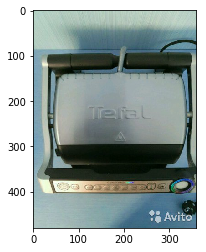

343 907


In [93]:
# Checking for SIFT and FAST Keypoints extractions

img = os.path.join(images_path, features.image[200])
img = cv2.imread(img)
plt.imshow(img)
plt.show()

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
fast = cv2.FastFeatureDetector_create()

s_kp = sift.detect(gray,None)
f_kp = fast.detect(gray,None)
print(len(s_kp), len(f_kp))

In [ ]:
# Saving in the end
features.to_pickle("/media/data/avito/preprocessed/image_train_feat_f29.pkl")